# **First** autoencoder

## Importing data

In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd

from DATA_generator import *

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

#using lorenzos code from R
#import rpy2.robjects as robjects
#from rpy2.robjects import pandas2ri

In [2]:
bigData = pd.read_csv("/home/salati/CHIRAL/Pkg/CHIRAL/Example/Muscle_exon.txt", sep=" ")
#Taking only the rythmic genes
PeriodicData=bigData.loc[["ENSG00000105516", "ENSG00000049246", "ENSG00000167074", "ENSG00000174738", "ENSG00000179094", "ENSG00000132326" , "ENSG00000170485", "ENSG00000133794","ENSG00000126368","ENSG00000008405","ENSG00000121671","ENSG00000159208"]]
DATA=torch.tensor(PeriodicData.values)
DATA=DATA.float()
E=np.array(PeriodicData.values)

In [3]:
true_phases=pd.read_csv("/home/salati/CHIRAL/Pkg/CHIRAL/Example/true_phi.txt",sep=" ")
true_phases=np.array(true_phases.values)
true_phases=true_phases[:,0]


In [4]:
N_Genes=DATA.shape[0]
N_Samples=DATA.shape[1]
N_Samples

57

Select gene you are interested setting varaible g in order to plot data, and supposed distribution

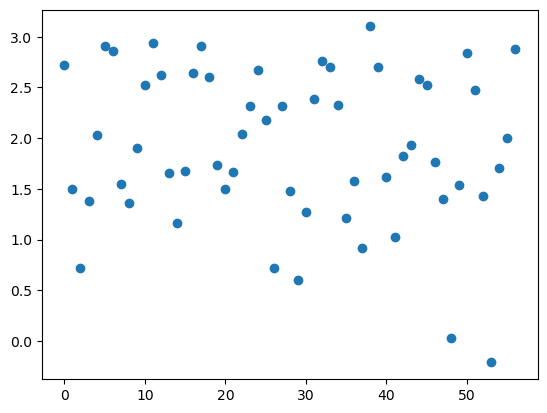

In [5]:
plt.plot(DATA[1,:], 'o')

## PCA

In [6]:
Et=np.transpose(E)
pca=PCA(n_components=2)
pca.fit(Et)

PCA(n_components=2)

In [7]:
pca.explained_variance_ratio_
PCA_base=pca.components_
PCA_base=np.array(PCA_base)
print('The two vectors are orthogonal, the scalar priduct is: ',np.matmul(PCA_base[0,:] ,PCA_base[1,:]) )


The two vectors are orthogonal, the scalar priduct is:  -2.7755575615628914e-17


In [8]:
pca_points=pca.fit_transform(Et)

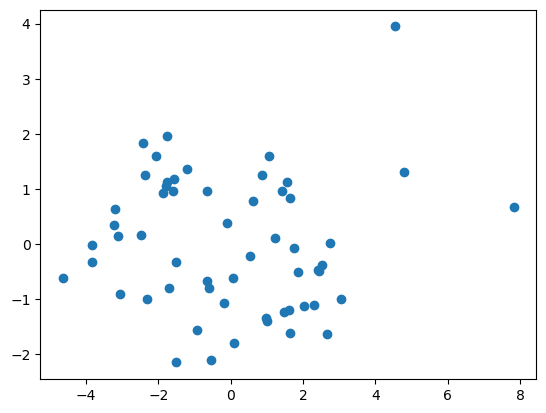

In [9]:
plt.plot(pca_points[:,0] , pca_points[:,1], 'o')

In [28]:
from DATA_generator import *
PCA_phi=np.arctan2(pca_points[:,0],pca_points[:,1])
PCAshifted_phi,madPCA=optimal_shift(PCA_phi, true_phases)
madPCA

0.33878580216854104

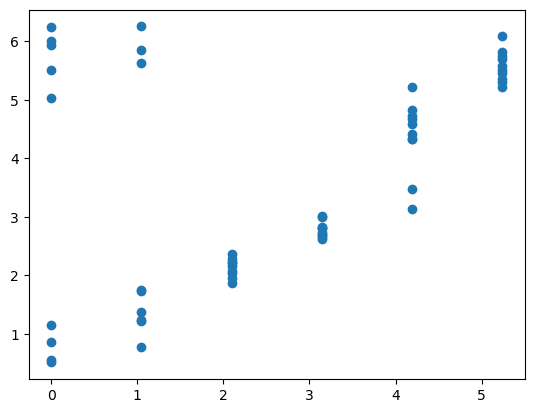

In [17]:
plt.plot(true_phases,PCAshifted_phi, 'o')

## Torch Linear

### Setting the network

In [18]:
PCA_tensor=torch.tensor(PCA_base)
PCA_tensor=PCA_tensor.float()

In [19]:
class LinearEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(N_Genes, 2,bias=False)
        #self.encoder.weight=nn.Parameter(PCA_tensor)

        self.decoder = nn.Linear(2, N_Genes,bias=False)
        #self.decoder.weight=nn.Parameter(PCA_tensor.transpose(0,1))
           
    #fucntion that makes the input flow in the network
    def forward(self, x):
        encoded=self.encoder(x) #compress the input
        decoded=self.decoder(encoded)

        return decoded

Here I create an instance of the class LinearEncoder and define other important stuff like the loss function

In [20]:
model = LinearEncoder()
criterion= nn.MSELoss()
#optimizer = torch.optim.SGD(model.parameters(),lr=0.00001)
optimizer=torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


Adding the GPU stuff

In [21]:
#for GPU use this block

#device = torch.device('mps')
#E_t=torch.from_numpy(E)
#E_t=E_t.float()
#DATA=torch.tensor(E_t,  device=device)
#model.to(device)


# for CPU keep this line

Training cycle

In [22]:
#recon= reconstruction of the input
num_epochs=600
outputs=[]

for epoch in range(num_epochs):
 
  for sample in range(N_Samples):
    input=DATA[:,sample]
    recon=model(input)
    loss=criterion(recon,input)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #added this line to compare with the circular model, thisline block the convergence
  if loss.item() < 0.0005 :
    break
  if (epoch % 30 ==0):
    print("epoch ",epoch,"Loss", loss.item())

epoch  0 Loss 7.529235363006592
epoch  30 Loss 0.42126187682151794
epoch  60 Loss 0.4121328592300415
epoch  90 Loss 0.394842267036438
epoch  120 Loss 0.36293864250183105
epoch  150 Loss 0.31032291054725647
epoch  180 Loss 0.2342321127653122
epoch  210 Loss 0.14973387122154236
epoch  240 Loss 0.08054593950510025
epoch  270 Loss 0.041552964597940445
epoch  300 Loss 0.0335598848760128
epoch  330 Loss 0.03708677366375923
epoch  360 Loss 0.04145926609635353
epoch  390 Loss 0.04457710683345795
epoch  420 Loss 0.04653504118323326
epoch  450 Loss 0.0477168895304203
epoch  480 Loss 0.04841991141438484
epoch  510 Loss 0.04884092137217522
epoch  540 Loss 0.049100011587142944
epoch  570 Loss 0.04926391318440437


Grabbing the weights of the first layer which are the analogous of the eigenvectors in PCA

In [23]:
encoder_base=model.encoder.weight
#print(encoder_base)
decoder_base=model.decoder.weight
#print(decoder_base)

Checking how the scalar product of the two vectors of the "basis" is

In [24]:
torch.dot(encoder_base[0,:],encoder_base[1,:] )

tensor(0.1364, grad_fn=<DotBackward0>)

In [25]:
NNphases=np.zeros((N_Samples,2))
for sample in range(N_Samples):
  temp=torch.matmul(encoder_base, DATA[:,sample]).detach().numpy()
  NNphases[sample,:]=temp

### Plots

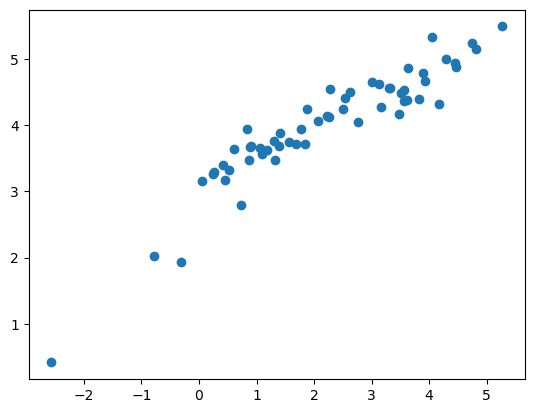

In [26]:
plt.plot(NNphases[:,0], NNphases[:,1],'o')

In [29]:
inf_phases=np.arctan2( NNphases[:,0],NNphases[:,1] )
NNshifted_phi,mad=optimal_shift(inf_phases, true_phases)
mad

0.8633612231807364

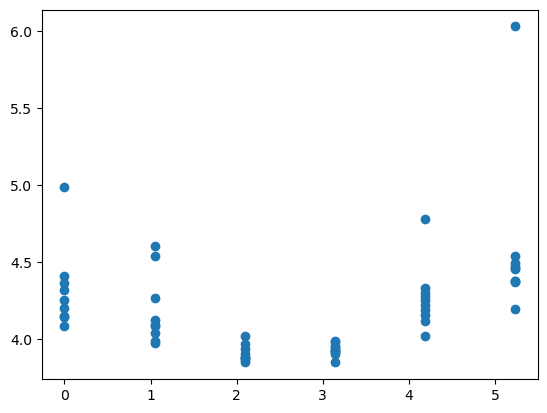

In [31]:
plt.plot(true_phases,NNshifted_phi,'o')

## Adding the "circular" activation function

### Setting the network

In [34]:
#SAME THING BUT USING SEQUENTIAL
'''
class CircularEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(N_Genes, 2,bias=False)
           )
        self.decoder = nn.Sequential(
            nn.Linear(2, N_Genes,bias=False)
           )
    #fucntion that makes the input flow in the network
    def forward(self, x):
        encoded=self.encoder(x) #compress the input
        encoded_circ=encoded/torch.linalg.norm(encoded)
        decoded=self.decoder(encoded_circ)

        return decoded #encoded,encoded_circ 
        '''

'\nclass CircularEncoder(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.encoder = nn.Sequential(\n            nn.Linear(N_Genes, 2,bias=False)\n           )\n        self.decoder = nn.Sequential(\n            nn.Linear(2, N_Genes,bias=False)\n           )\n    #fucntion that makes the input flow in the network\n    def forward(self, x):\n        encoded=self.encoder(x) #compress the input\n        encoded_circ=encoded/torch.linalg.norm(encoded)\n        decoded=self.decoder(encoded_circ)\n\n        return decoded #encoded,encoded_circ \n        '

In [35]:
class CircularEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(N_Genes, 2,bias=False)
        #self.encoder.weight=nn.Parameter(PCA_tensor)

        self.decoder = nn.Linear(2, N_Genes,bias=False)
        #self.decoder.weight=nn.Parameter(PCA_tensor.transpose(0,1))
    
    #fucntion that makes the input flow in the network
    def forward(self, x):
        encoded=self.encoder(x) #compress the input
        encoded_circ=encoded/torch.linalg.norm(encoded)

        decoded=self.decoder(encoded_circ)

        return decoded #encoded,encoded_circ 

In [36]:
circ_model=CircularEncoder()
criterion2= nn.MSELoss()
optimizer2 = torch.optim.Adam(circ_model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer2 = torch.optim.SGD(circ_model.parameters(),lr=0.001)


In [44]:
#recon= reconstruction of the input
num_epochs=300
outputs=[]

for epoch in range(num_epochs):
  for sample in range(N_Samples):
    input=DATA[:,sample]
    recon=circ_model(input)
    loss=criterion2(recon,input)

    optimizer2.zero_grad()
    loss.backward()
    optimizer2.step()
  if (epoch % 10 ==0):
    print("epoch ",epoch,"Loss", loss.item())

epoch  0 Loss 0.5997452139854431
epoch  10 Loss 0.5568024516105652
epoch  20 Loss 0.5248780250549316
epoch  30 Loss 0.5013834238052368
epoch  40 Loss 0.48390427231788635
epoch  50 Loss 0.47076401114463806
epoch  60 Loss 0.46044135093688965
epoch  70 Loss 0.45189204812049866
epoch  80 Loss 0.4445314407348633
epoch  90 Loss 0.43788620829582214
epoch  100 Loss 0.4316818416118622
epoch  110 Loss 0.4257735311985016
epoch  120 Loss 0.4200828969478607
epoch  130 Loss 0.41457343101501465
epoch  140 Loss 0.4092320501804352
epoch  150 Loss 0.4040561020374298
epoch  160 Loss 0.3990461826324463
epoch  170 Loss 0.3942008912563324
epoch  180 Loss 0.38951364159584045
epoch  190 Loss 0.38497254252433777
epoch  200 Loss 0.3805590867996216
epoch  210 Loss 0.37625232338905334
epoch  220 Loss 0.3720306158065796
epoch  230 Loss 0.3678741753101349
epoch  240 Loss 0.36376747488975525
epoch  250 Loss 0.35970088839530945
epoch  260 Loss 0.35567203164100647
epoch  270 Loss 0.35168322920799255
epoch  280 Loss 0.

In [45]:
circ_encoder_base=circ_model.encoder.weight
print(encoder_base)
circ_decoder_baseC=circ_model.decoder.weight
#print(decoder_base)


Parameter containing:
tensor([[ 0.2672,  0.1852,  0.1822,  0.0626,  0.2479,  0.1501, -0.0562, -0.2864,
          0.1008, -0.0704,  0.0031,  0.4034],
        [ 0.0223,  0.1337,  0.1866,  0.3076,  0.1658,  0.0887, -0.0978,  0.0815,
          0.1828,  0.0587,  0.2943,  0.0016]], requires_grad=True)


After having the values of the weight, in order to find the values of the neurons, i just reconstruct waht happens to the input until the the bottle neck (encoder linear layer + unit circle projection)

In [46]:
NNphasesC=np.zeros((N_Samples,2))
print(DATA[:,0])

temp=torch.matmul(circ_encoder_base, DATA[:,0]).detach().numpy()
print(temp)

temp /= np.linalg.norm(temp)
print(temp)

np.linalg.norm( temp)


tensor([ 1.7769,  2.7178,  3.2389,  4.0250,  2.7864,  1.5765, -2.2893, -1.1756,
         1.6560,  0.5669,  3.4082,  2.0304])
[ 1.3511041  -0.69462985]
[ 0.88934773 -0.45723158]


1.0

In [47]:
NNphasesC=np.zeros((2,N_Samples))
for sample in range(N_Samples):
  temp=torch.matmul(circ_encoder_base, DATA[:,sample]).detach().numpy()
  NNphasesC[:,sample]=temp
  NNphasesC[:,sample] /= np.linalg.norm(NNphasesC[:,sample])


### Plots

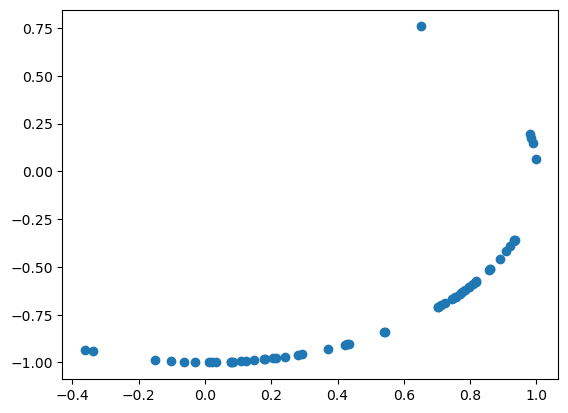

In [48]:
plt.plot(NNphasesC[0,:], NNphasesC[1,:],'o')

In [49]:
inf_phasesC=np.arctan2( NNphasesC[0,:],NNphasesC[1,:] )

NNshifted_phi,mad=optimal_shift(inf_phasesC, true_phases)

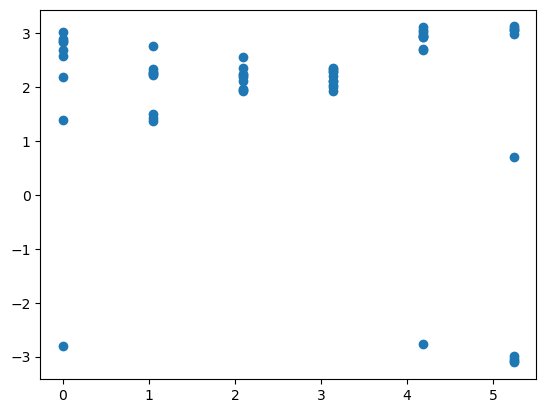

In [50]:
plt.plot(true_phases,inf_phasesC,'o')